<a href="https://www.kaggle.com/code/alexredna/datawagon-hackaton?scriptVersionId=150351412" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import QuantileTransformer, RobustScaler
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir(os.path.dirname(os.getcwd())) 
import warnings
warnings.filterwarnings("ignore")

In [2]:
RAND_STATE = 42
#FEATURES = ['period', 'real_weight', 'real_wagon_count']
#FEATURES_TO_PREDICT = ['period', 'forecast_wagon_count', 'forecast_weight']
FEATURES = []
FEATURES_TO_PREDICT = []
FEATURES_FOR_PREPROCESSING_BEFORE_FIT = ['podrod', 'sender_railway_name', 'sender_station_id', 'holding_name']
TARGETS = ['period', 'forecast_weight', 'forecast_wagon_count']
FINAL_ROWCOUNT = 0
PATH = '/kaggle/input/datawagon-track-1/'
WORK_PATH = '/kaggle/working/'

# Data preparation

прогноз на апрель - август 2023, сделанный на данных до марта включительно

In [3]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = PATH + "client_mapping.csv"
    freight_mapping_file = PATH + "freight_mapping.csv"
    station_mapping_file = PATH + "station_mapping.csv"

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df

In [4]:
def preprocessing_before_fit(data: pd.DataFrame, column_names: list[str]) -> pd.DataFrame:
    for name in column_names:
        counts = data[name].value_counts()

        to_remove = counts[counts < 100].index

        data = data[~data[name].isin(to_remove)]
        
    mask = ((data['real_weight'] == 0) & (data['real_wagon_count'] > 300)) | ((data['real_weight'] > 0) & (data['real_wagon_count'] == 0)) | (data['real_weight'] < 0)
    data = data[~mask]

    FINAL_ROWCOUNT = STARTING_ROWCOUNT - data.shape[0]
    print(
        f'Lost {FINAL_ROWCOUNT} rows ({(FINAL_ROWCOUNT) / STARTING_ROWCOUNT * 100:.2f}% after marksiska data preprocessing)'
    )

    return data

In [5]:
rs = RobustScaler()
qt = QuantileTransformer(n_quantiles=10, random_state=0)

def preprocessing_features(scaler: RobustScaler, normalizer: QuantileTransformer, data: pd.DataFrame, features: list) -> pd.DataFrame:    
    if features == []:
        return data
    
    data[features] = scaler.fit_transform(
        data[features]
    )
    data[features] = normalizer.fit_transform(
        data[features]
    )

    FINAL_ROWCOUNT = STARTING_ROWCOUNT - data.shape[0]
    print(
        f'Lost {FINAL_ROWCOUNT} rows ({(FINAL_ROWCOUNT) / STARTING_ROWCOUNT * 100:.2f}% after preprocessing)'
    )
    
    return data

def rollback_preprocessing_features(scaler: RobustScaler, normalizer: QuantileTransformer, data: pd.DataFrame, targets: list) -> pd.DataFrame:
    data[targets] = normalizer.inverse_transform(
        data[targets]
    )
    data[targets] = scaler.inverse_transform(
        data[targets]
    )

    FINAL_ROWCOUNT = STARTING_ROWCOUNT - data.shape[0]
    print(
        f'Lost {FINAL_ROWCOUNT} rows ({(FINAL_ROWCOUNT) / STARTING_ROWCOUNT * 100:.2f}% after preprocessing rollback)'
    )
    
    return data

In [6]:
ds = pd.read_csv(PATH + "fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
STARTING_ROWCOUNT = ds.shape[0]
ds = add_master_data_mappings(ds)
ds['holding_name'] = ds['holding_name'].fillna(0).astype(int)
ds['period'] = [time.mktime(datetime.strptime(n, '%Y-%m-%d').date().timetuple()) / 1000000000 - 1 for n in ds['period']]
#ds['real_weight'] = ds['real_weight'].str.replace(',', '.').astype(np.float64)
ds = preprocessing_features(
    scaler=rs, 
    normalizer=qt,
    data=preprocessing_before_fit(ds, FEATURES_FOR_PREPROCESSING_BEFORE_FIT),
    features=FEATURES
)

for column in ds.columns:
    if column not in ('period', 'real_weight', 'real_wagon_count'):
        ds[column] = ds[column].astype('category')
        
display(ds.sample(5))

Lost 230933 rows (6.49% after marksiska data preprocessing)


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
248068,0.493597,1,5,1,-1,1117,23644,24049,9889,339.0,5,0,31,123,31,77,31
150583,0.488326,1,5,1,188,1649,37642,33120,7444,124.0,2,1814,11,55,3,43,29
1588977,0.567296,0,0,1,2353,3348,35218,38641,151,113.0,2,681,19,9,10,158,6
931023,0.530403,0,1,1,22,1513,28036,25125,10007,201.0,3,1459,38,25,27,92,31
878118,0.527811,0,1,0,1233,543,13637,29533,10010,132.0,2,222,2,10,30,24,11


In [7]:
#display(sns.distplot(ds['period']))

In [8]:
#display(sns.distplot(ds['real_weight']))

In [9]:
#display(sns.distplot(ds['real_wagon_count']))

## Train test split

data.drop(['sender_station_id', 'recipient_station_id', 'freight_id', 'client_sap_id'], axis=1, inplace=True)

In [10]:
x = ds[ds.columns.difference(['real_weight', 'real_wagon_count'])]
display(x.sample(5))
y = ds[['real_weight', 'real_wagon_count']]
display(y.sample(5))

,client_sap_id,filial,freight_group_name,freight_id,holding_name,period,podrod,recipient_department_name,recipient_railway_name,recipient_station_id,rps,sender_department_name,sender_organisation_id,sender_railway_name,sender_station_id
2911516,1096,1,6,728,691,0.640995,4,23,6,38966,1,8,30853,16,36430
1798714,431,1,11,1649,962,0.577837,5,160,43,34400,1,119,18478,29,32795
1981884,163,1,31,1059,1048,0.588291,5,118,11,29144,1,86,7142,39,26792
1142369,1634,0,6,729,1575,0.541030,4,133,25,2204,1,8,7253,16,36418
250851,-1,1,39,1698,0,0.493597,5,21,12,31343,1,17,8539,39,20249


,real_weight,real_wagon_count
2748085,67.0,1
1510669,516.0,8
17529,462.0,7
509467,13003.0,176
412834,939.0,14


In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3328299 entries, 0 to 3559231
Data columns (total 15 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   client_sap_id              category
 1   filial                     category
 2   freight_group_name         category
 3   freight_id                 category
 4   holding_name               category
 5   period                     float64 
 6   podrod                     category
 7   recipient_department_name  category
 8   recipient_railway_name     category
 9   recipient_station_id       category
 10  rps                        category
 11  sender_department_name     category
 12  sender_organisation_id     category
 13  sender_railway_name        category
 14  sender_station_id          category
dtypes: category(14), float64(1)
memory usage: 119.1 MB


In [12]:
categorical_indicies = [n for n in x.columns if n != 'period']
categorical_indicies

['client_sap_id',
 'filial',
 'freight_group_name',
 'freight_id',
 'holding_name',
 'podrod',
 'recipient_department_name',
 'recipient_railway_name',
 'recipient_station_id',
 'rps',
 'sender_department_name',
 'sender_organisation_id',
 'sender_railway_name',
 'sender_station_id']

In [13]:
data = cb.Pool(
    x,
    y, 
    cat_features=categorical_indicies
)

# Training

In [14]:
params = {
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True,
          'cat_features' : categorical_indicies,
          'random_state' : RAND_STATE,
          'verbose' : 10,
          'early_stopping_rounds' : 10,
          'learning_rate': 0.2,
          'depth': 10,
          'l2_leaf_reg': 8,
          'iterations': 19
         }

model = cb.CatBoostRegressor(**params)

fit_model = model.fit(data, early_stopping_rounds = 5)

0:	learn: 8842.6592048	total: 11.9s	remaining: 3m 33s
10:	learn: 7461.7200038	total: 1m 47s	remaining: 1m 18s
18:	learn: 7155.6325601	total: 3m 4s	remaining: 0us


In [15]:
model.save_model('/kaggle/working/ehh.cbm') 
#model.load_model('/kaggle/working/ehh.cbm')

# Model evaluation

In [16]:
def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

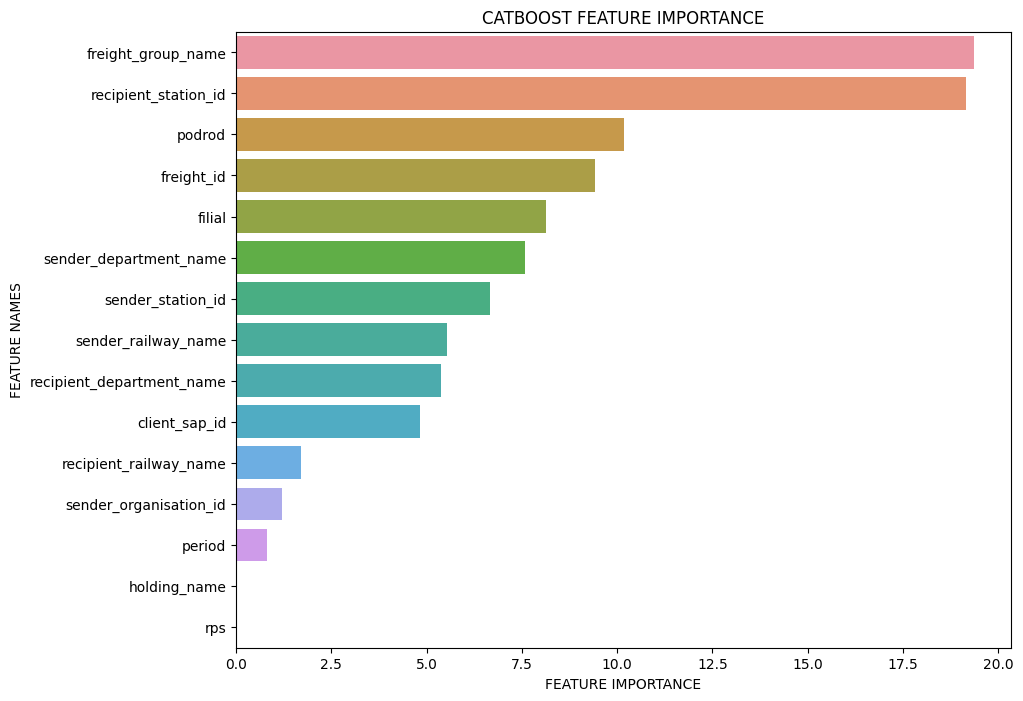

In [17]:
plot_feature_importance(model.get_feature_importance(),x.columns,'CATBOOST')

In [18]:
# plot distribution of real_weight and real_wagon_count
def plot_feature_distibution(columns_to_plot: list[str]) -> None:
    _, ax = plt.subplots(1, len(columns_to_plot), figsize=(15, 5))

    sns.distplot(data[columns_to_plot[0]], ax=ax[0])
    sns.distplot(data[columns_to_plot[1]], ax=ax[1])
    sns.distplot(data[columns_to_plot[2]], ax=ax[2])
    plt.show()

# Final prediction

In [19]:
forecast_example = pd.read_csv(PATH + "forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")
display(forecast_example)
forecast_mastered = add_master_data_mappings(forecast_example)
forecast_mastered['holding_name'] = forecast_mastered['holding_name'].fillna(0).astype(int)
forecast_mastered['period'] = [time.mktime(datetime.strptime(n, '%Y-%m-%d').date().timetuple()) / 1000000000 - 1 for n in forecast_mastered['period']]
forecast_mstered = preprocessing_features(
    scaler=rs, 
    normalizer=qt,
    data=forecast_mastered,
    features=FEATURES_TO_PREDICT
)

x_pred = forecast_mastered[forecast_mastered.columns.difference(['forecast_weight', 'forecast_wagon_count'])]

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,73.0,1
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,146.0,2
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,876.0,12
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,473.0,7
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,63.0,1
...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,69.0,1
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,207.0,3


In [20]:
predict = pd.DataFrame(model.predict(x_pred))

forecast_mastered['forecast_weight'] = pd.DataFrame(predict)[0]
forecast_mastered['forecast_wagon_count'] = pd.DataFrame(predict)[1]

display(forecast_mastered)
'''
forecast_mastered = rollback_preprocessing_features(
    scaler=rs, 
    normalizer=qt,
    data=forecast_mastered,
    targets=FEATURES_TO_PREDICT
)
'''

forecast_example['forecast_weight'] = forecast_mastered['forecast_weight']
forecast_example['forecast_wagon_count'] = forecast_mastered['forecast_wagon_count']
display(forecast_example)

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,0.680307,0,0,0,2275,3291,23976,26423,27983,176.468068,2.635131,13,20,77,31,124,5
1,0.680307,0,0,0,2275,3294,23976,26423,27983,176.468068,2.635131,13,20,77,31,124,5
2,0.680307,0,0,0,2275,3294,23976,24516,27983,213.749194,3.250685,13,20,77,31,147,31
3,0.680307,0,0,0,-1,349,38725,38966,27437,540.123271,8.386609,0,10,23,6,23,6
4,0.680307,0,0,0,-1,349,38754,38966,26664,540.123271,8.386609,0,10,23,6,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,0.690848,1,5,2,1346,1482,31438,31482,0,208.664092,3.636384,2226,22,73,14,143,35
239601,0.690848,1,5,2,1346,1492,31438,36091,27275,277.353232,4.862720,2226,22,73,14,79,10
239602,0.690848,1,5,2,1346,1492,31438,35450,27275,229.467996,4.271017,2226,22,73,14,104,10
239603,0.690848,1,5,2,1346,1492,31438,31482,0,159.253098,2.807233,2226,22,73,14,143,35


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,176.468068,2.635131
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,176.468068,2.635131
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,213.749194,3.250685
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,540.123271,8.386609
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,540.123271,8.386609
...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,208.664092,3.636384
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,277.353232,4.862720
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,229.467996,4.271017
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,159.253098,2.807233


In [21]:
forecast_mastered

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,0.680307,0,0,0,2275,3291,23976,26423,27983,176.468068,2.635131,13,20,77,31,124,5
1,0.680307,0,0,0,2275,3294,23976,26423,27983,176.468068,2.635131,13,20,77,31,124,5
2,0.680307,0,0,0,2275,3294,23976,24516,27983,213.749194,3.250685,13,20,77,31,147,31
3,0.680307,0,0,0,-1,349,38725,38966,27437,540.123271,8.386609,0,10,23,6,23,6
4,0.680307,0,0,0,-1,349,38754,38966,26664,540.123271,8.386609,0,10,23,6,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,0.690848,1,5,2,1346,1482,31438,31482,0,208.664092,3.636384,2226,22,73,14,143,35
239601,0.690848,1,5,2,1346,1492,31438,36091,27275,277.353232,4.862720,2226,22,73,14,79,10
239602,0.690848,1,5,2,1346,1492,31438,35450,27275,229.467996,4.271017,2226,22,73,14,104,10
239603,0.690848,1,5,2,1346,1492,31438,31482,0,159.253098,2.807233,2226,22,73,14,143,35


submit

In [22]:
forecast_example.to_csv("/kaggle/working/forecast_example.csv", index=False, sep=";", decimal=",", encoding="windows-1251")